# Setup

In [1]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Prepare train and test data
train_dataset = MNIST(download=True, root='data', train=True, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = MNIST(download=True, root='data', train=False, transform=ToTensor())
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)

/opt/homebrew/Caskroom/miniforge/base/envs/bachelor-project/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Make results reproducible
random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [4]:
# Membrane time constant
T_RC = 0.02
T_REF = 4e-3
V_TH = 1.0

In [5]:
def sigmoid(x, deriv=False):
  out = F.sigmoid(x)
  if deriv:
    return out * (1 - out)
  return out

def leaky_relu(x, deriv=False):
  factor = (x > 0) + 0.1
  if deriv:
    return factor
  return factor * x

def rate(x, p=torch.relu, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, epsilon=1e-12, deriv=False):
  b = (p(x - V_th) + epsilon)
  l = 1 + V_th / b
  r = torch.reciprocal(t_ref + t_rc * torch.log(l))
  if deriv:
    return (r ** 2) * t_rc / l * V_th / (b ** 2) * p(x - V_th, deriv=True)
  return r

def soft_plus(x, beta=20, threshold=20, deriv=False):
  if deriv:
    out = 1 / beta * 1 / (1 + torch.exp(beta * x)) * beta * torch.exp(beta * x)
    out[beta * x > threshold] = 1
    return out
  return torch.nn.functional.softplus(x, beta=beta, threshold=threshold)

def soft_rate(x, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, deriv=False):
  if deriv:
    return rate(x, p=soft_plus, t_rc=t_rc, t_ref=t_ref, V_th=V_th, deriv=True)
  return rate(x, p=soft_plus, t_rc=t_rc, t_ref=t_ref, V_th=V_th)

def scaled_soft_rate(x, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, scale = 0.05, deriv=False):
  if deriv:
    return soft_rate(x, t_rc=t_rc, t_ref=t_ref, V_th=V_th, deriv=True) * scale
  return soft_rate(x, t_rc=t_rc, t_ref=t_ref, V_th=V_th) * scale

def softmax(x, deriv=False):
  if deriv:
    # This is little unusual, but is required to calculate correct the correct partial derivate if e = x - u
    return torch.ones_like(x) 
  return x.exp() / x.exp().sum(dim=1, keepdim=True)

def onehot(x, n_classes):
  return torch.eye(n_classes)[x]

def get_weights_and_biases(in_features, out_features):
  W = torch.randn((out_features, in_features)) * 2/math.sqrt(in_features)
  b = torch.zeros(out_features)

  return W, b

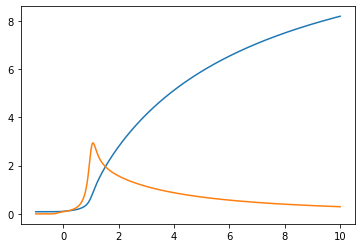

In [6]:
x = torch.linspace(-1, 10, 1000)
r = scaled_soft_rate(x)
dr = scaled_soft_rate(x, deriv=True)

plt.plot(x, r)
plt.plot(x, dr)

plt.show()

# Back-propagation

In [13]:
# Define out layer sizes
in_features = 784
hidden1_features = 32
hidden2_features = 32
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden1_features)
W2, b2 = get_weights_and_biases(hidden1_features, hidden2_features)
W3, b3 = get_weights_and_biases(hidden2_features, out_features)

activation1 = leaky_relu
activation2 = leaky_relu
activation3 = softmax

In [ ]:
# Baseline backprop model
class MLP(nn.Module):
  def __init__(self, in_features, hidden1_features, hidden2_features, out_features):
    super().__init__()
    self.l1 = nn.Linear(in_features, hidden1_features)
    self.l2 = nn.Linear(hidden1_features, hidden2_features)
    self.l3 = nn.Linear(hidden2_features, out_features)

    # Start with exactly the same weights.
    with torch.no_grad():
      self.l1.weight.copy_(W1)
      self.l1.bias.copy_(b1)
      self.l2.weight.copy_(W2)
      self.l2.bias.copy_(b2)
      self.l3.weight.copy_(W3)
      self.l3.bias.copy_(b3)

  def forward(self, x):
    x = activation1(self.l1(x))
    x = activation2(self.l2(x))
    x = self.l3(x)
    return x


model = MLP(in_features, hidden1_features, hidden2_features, out_features)

In [17]:
loss_history = []
accuracy_history = []
step = 0
accuracy = 0
loss = None

In [18]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

NameError: name 'model' is not defined

In [ ]:
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1

    optimizer.zero_grad()
    x0 = images.flatten(start_dim=1)

    pred = model(x0)
    loss = criterion(pred, labels)
    loss.backward()
    
    loss_history.append((step, loss.item()))

    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")

    optimizer.step()

    if step % 100 == 0: 
      model.eval()
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        x3_pred = model(x0)
        pred_labels = x3_pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested
      

      accuracy_history.append((step, accuracy))
      model.train()
    

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

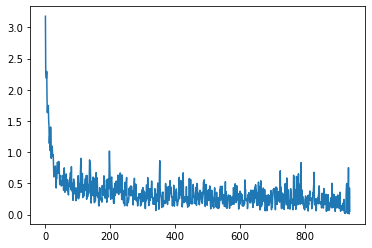

In [ ]:
plt.plot(*zip(*loss_history))
plt.show()

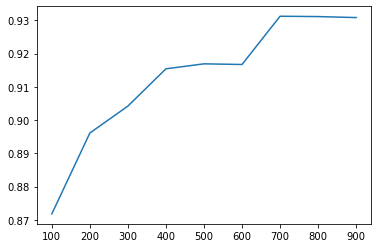

In [ ]:
plt.plot(*zip(*accuracy_history))
plt.show()

In [ ]:
# Save loss and accuracy history
torch.save(loss_history, "../results/backprop-loss_history.pt")
torch.save(accuracy_history, "../results/backprop-accuracy_history.pt")

In [ ]:
torch.save(model.state_dict(), "../results/backprop/model.py")

In [ ]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  x3_pred = model(x0)
  pred_labels = x3_pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy * 100}%")

KeyboardInterrupt: 

In [ ]:
logits = torch.tensor([[2.0, 5.0, 2.0, 2.0, 2.0], [2.0, 5.0, 2.0, 2.0, 2.0]])
pred = softmax(logits)
labels = torch.tensor([1, 2])

print(nn.CrossEntropyLoss()(logits, labels))
print(-(torch.log(pred) * torch.stack([onehot(label, pred.shape[1]) for label in labels])).sum(dim=1).mean())

tensor(1.6816)
tensor(1.6816)


# Inference Learning

In [ ]:
# Define out layer sizes
in_features = 784
hidden1_features = 32
hidden2_features = 32
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden1_features)
W2, b2 = get_weights_and_biases(hidden1_features, hidden2_features)
W3, b3 = get_weights_and_biases(hidden2_features, out_features)

activation1 = leaky_relu
activation2 = leaky_relu
activation3 = softmax

NameError: name 'get_weights_and_biases' is not defined

In [ ]:
loss_history = []
accuracy_history = []
accuracy = 0
loss = 0
step = 0

In [ ]:
# Setup hyperparameters
ir = 4e-1 # Inference rate
lr = 1e-1 # Learning rate

# Should we just test the inference part
test = True

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

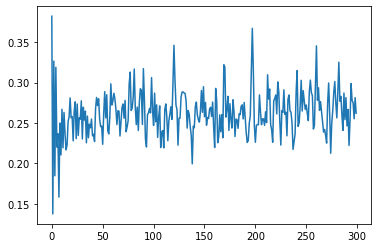

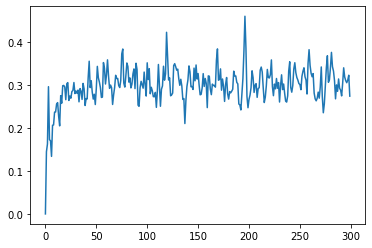

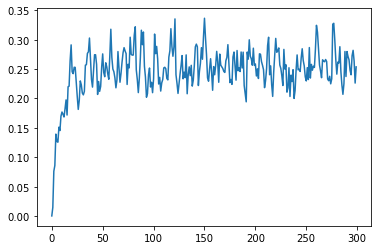

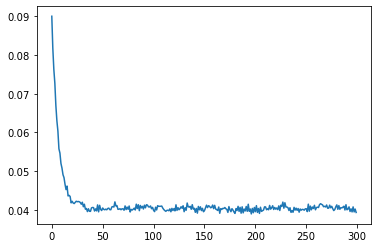

In [ ]:
# Training loop
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)
    batch_dim = x0.shape[0]
    x1 = torch.zeros((batch_dim, hidden1_features))
    x2 = torch.zeros((batch_dim, hidden2_features))
    x3 = torch.zeros((batch_dim, out_features))

    x4 = onehot(labels, n_classes=10) # Constrain output to be the correct labels.

    x4_pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)

    loss = -(torch.log(x4_pred) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss:.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))
    errors_history = []

    # Run predictive coding inference. 
    for t in range(300):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = activation3(x3)

      # Calculate errors
      e1 = x1 - u1
      e2 = x2 - u2
      e3 = x3 - u3
      e4 = x4 - u4

      # Canculate derivatives
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      dx3 = -e3 + activation3(x3, deriv=True) * (e4)
      #dx4 = -e4 # Only do this during prediction

      # Do actual steps
      x1 += ir * dx1
      x2 += ir * dx2
      x3 += ir * dx3
      #x4 -= ir * dx4 # Only do this during inference.

      if test:
        errors_history.append(((e1 ** 2).mean(), (e2 ** 2).mean(), (e3 ** 2).mean(), (e4 ** 2).mean()))

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    if test:
      break

    # Calculate gradients
    dW1 = e1[:, :, None] @ x0[:, None, :]
    dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
    dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]

    db1 = e1
    db2 = e2
    db3 = e3

    # Perform weight update here.
    W1 += lr * dW1.mean(dim=0)
    b1 += lr * db1.mean(dim=0)

    W2 += lr * dW2.mean(dim=0)
    b2 += lr * db2.mean(dim=0)

    W3 += lr * dW3.mean(dim=0)
    b3 += lr * db3.mean(dim=0)

    if step % 100 == 0:
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()

      accuracy = correct / tested
      accuracy_history.append((step, accuracy))

  if test:
    break

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([1

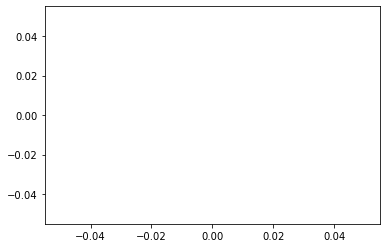

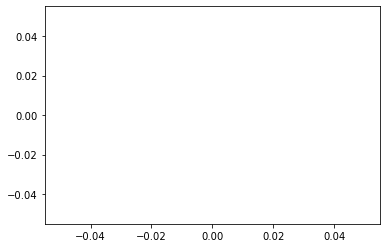

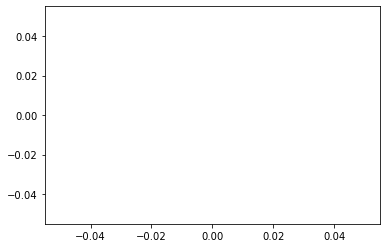

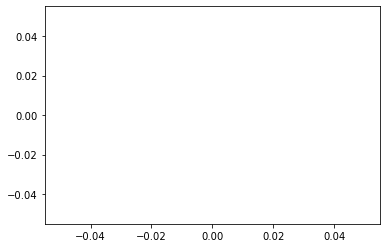

In [ ]:
# Training loop
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)

    # Initialize x's with forward predictions
    x1 = u1 = x0 @ W1.T + b1
    x2 = u2 = activation1(x1) @ W2.T + b2
    x3 = u3 = activation2(x2) @ W3.T + b3
    u4 = activation3(x3)

    x4 = onehot(labels, n_classes=10) # Constrain output to be the correct labels.

    x4_pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)

    loss = -(torch.log(x4_pred) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss:.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))
    errors_history = []

    # Run predictive coding inference. 
    for t in range(40):
      u4 = activation3(x3)
      e4 = x4 - u4


      u3 = activation2(x2) @ W3.T + b3
      e3 = x3 - u3

      print(activation2(x2, deriv=True).shape, e2.shape, e3.shape, W3.shape)

      dx3 = -e3 + activation3(x3, deriv=True) * (e4)
      x3 += ir * dx3
      
      u2 = activation1(x1) @ W2.T + b2
      e2 = x2 - u2
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += ir * dx2
      
      u1 = x0 @ W1.T + b1
      e1 = x1 - u1
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += ir * dx1

      if test:
        errors_history.append(((e1 ** 2).mean(), (e2 ** 2).mean(), (e3 ** 2).mean(), (e4 ** 2).mean()))

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    if test:
      break

    # Calculate gradients
    dW1 = e1[:, :, None] @ x0[:, None, :]
    dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
    dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]

    db1 = e1
    db2 = e2
    db3 = e3

    # Perform weight update here.
    W1 += lr * dW1.mean(dim=0)
    b1 += lr * db1.mean(dim=0)

    W2 += lr * dW2.mean(dim=0)
    b2 += lr * db2.mean(dim=0)

    W3 += lr * dW3.mean(dim=0)
    b3 += lr * db3.mean(dim=0)

    if step % 100 == 0:
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()

      accuracy = correct / tested
      accuracy_history.append((step, accuracy))

  if test:
    break

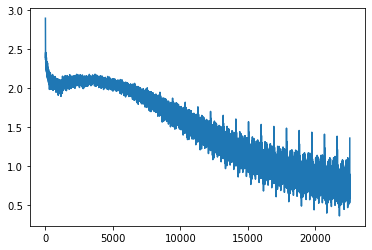

In [ ]:
plt.plot(*zip(*loss_history))
plt.show()

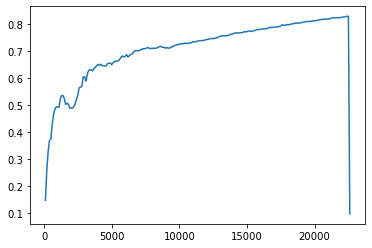

In [ ]:
plt.plot(*zip(*accuracy_history))
plt.show()

In [ ]:
# torch.save((W1, b1, W2, b2, W3, b3), "../results/inference-learning/model_1-epoch.pt")
# torch.save(loss_history, "../results/inference-learning/loss-history_1-epoch.pt")
# torch.save(accuracy_history, "../results/inference-learning/accuracy-history_1-epoch.pt")

In [ ]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
  pred_labels = pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
accuracy_history.append((step, accuracy))
print(accuracy)

tensor(0.9244)


# Zero Divergent Inference Learning

In [ ]:
# Define out layer sizes
in_features = 784
hidden1_features = 32
hidden2_features = 32
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden1_features)
W2, b2 = get_weights_and_biases(hidden1_features, hidden2_features)
W3, b3 = get_weights_and_biases(hidden2_features, out_features)

activation1 = leaky_relu
activation2 = leaky_relu
activation3 = softmax

In [ ]:
accuracy_history = []
loss_history = []
accuracy = 0
loss = 0
step = 0

In [ ]:
# Setup hyperparameters
ir = 1 # Inference rate (has to be 1 for Z-IL)
lr = 1e-1 # Learning rate

# Should we just test the inference part
test = False

In [ ]:
# Training loop
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)
    batch_dim = x0.shape[0]

    u1 = x1 = x0 @ W1.T + b1
    u2 = x2 = activation1(x1) @ W2.T + b2
    u3 = x3 = activation2(x2) @ W3.T + b3
    u4 = x4_pred = activation3(x3)

    x4 = onehot(labels, n_classes=10) # Constrain output to be the correct labels.
    loss = -(torch.log(x4_pred) * x4).sum(dim=1).mean()
    if step % 10 == 0:
      tqdm_train_data.set_description(f"Training - Loss: {loss:.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))

    for t in range(6):
      # Calculate errors
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = activation3(x3)

      e4 = x4 - u4
      #dx4 = -e4 # Only do this during inference
      #x4 -= ir * dx4 # Only do this during inference.

      e3 = x3 - u3
      dx3 = -e3 + activation3(x3, deriv=True) * (e4)
      x3 += ir * dx3

      e2 = x2 - u2
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += ir * dx2

      e1 = x1 - u1
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += ir * dx1


      if t == 1:
        dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]
        db3 = e3
        W3 += lr * dW3.mean(dim=0)
        b3 += lr * db3.mean(dim=0)
      elif t == 2:
        dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
        db2 = e2
        W2 += lr * dW2.mean(dim=0)
        b2 += lr * db2.mean(dim=0)
      elif t == 3:
        dW1 = e1[:, :, None] @ x0[:, None, :]
        db1 = e1
        W1 += lr * dW1.mean(dim=0)
        b1 += lr * db1.mean(dim=0)
      
    if test:
      break

    if step % 100 == 0:
      tqdm_train_data.set_description(f"Testing - Loss: {loss:.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()

      accuracy = correct / tested
      accuracy_history.append((step, accuracy))

  if test:
    break

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

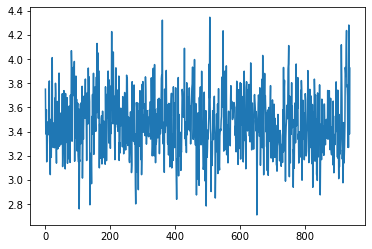

In [ ]:
plt.plot(*zip(*loss_history))
plt.show()

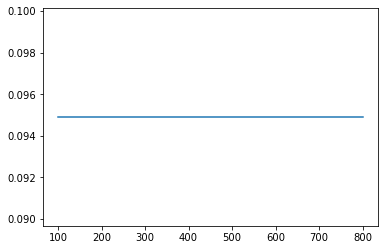

In [ ]:
plt.plot(*zip(*accuracy_history[:-1]))
plt.show()

# Experiment

In [151]:
hidden_dim = 300
W1, b1 = get_weights_and_biases(28*28, hidden_dim)
W2, b2 = get_weights_and_biases(hidden_dim, hidden_dim)
W3, b3 = get_weights_and_biases(hidden_dim, 10)
activation1 = scaled_soft_rate
activation2 = scaled_soft_rate

In [152]:
W1_og = W1.clone()
b1_og = b1.clone()
W2_og = W2.clone()
b2_og = b2.clone()
W3_og = W3.clone()
b3_og = b3.clone()

In [153]:
lr = 1e-2

In [154]:
loss_history = []
accuracy_history = []
step = 0
loss = 0
accuracy = 0

In [155]:
 W1 = W1_og.clone()
 b1 = b1_og.clone()
 W2 = W2_og.clone()
 b2 = b2_og.clone()
 W3 = W3_og.clone()
 b3 = b3_og.clone()

## Backprop

In [156]:
# Baseline backprop model
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super().__init__()
    self.l1 = nn.Linear(in_features, hidden_features)
    self.l2 = nn.Linear(hidden_features, hidden_features)
    self.l3 = nn.Linear(hidden_features, out_features)

    with torch.no_grad():
      self.l1.weight.copy_(W1)
      self.l1.bias.copy_(b1)
      self.l2.weight.copy_(W2)
      self.l2.bias.copy_(b2)
      self.l3.weight.copy_(W3)
      self.l3.bias.copy_(b3)

  def forward(self, x):
    return self.l3(activation2(self.l2(activation1(self.l1(x)))))


model = MLP(28*28, hidden_dim, 10)

In [157]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [158]:
step = 0
accuracy = 0
loss_history = []
accuracy_history = []

In [159]:
model.train()
for epoch in range(20):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1

    optimizer.zero_grad()
    x0 = images.flatten(start_dim=1)

    pred = model(x0)
    loss = criterion(pred, labels)
    loss.backward()
    
    loss_history.append((step, loss.item()))

    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")

    optimizer.step()

    if step % 200 == 0: 
      model.eval()
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        x3_pred = model(x0)
        pred_labels = x3_pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested
      

      accuracy_history.append((step, accuracy))
      model.train()
    

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20


  0%|          | 0/938 [00:00<?, ?it/s]

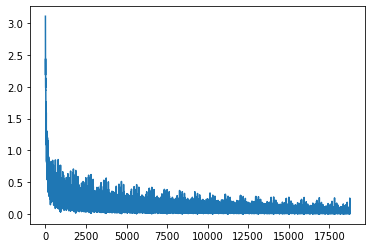

In [160]:
plt.plot(*zip(*loss_history))
plt.show()

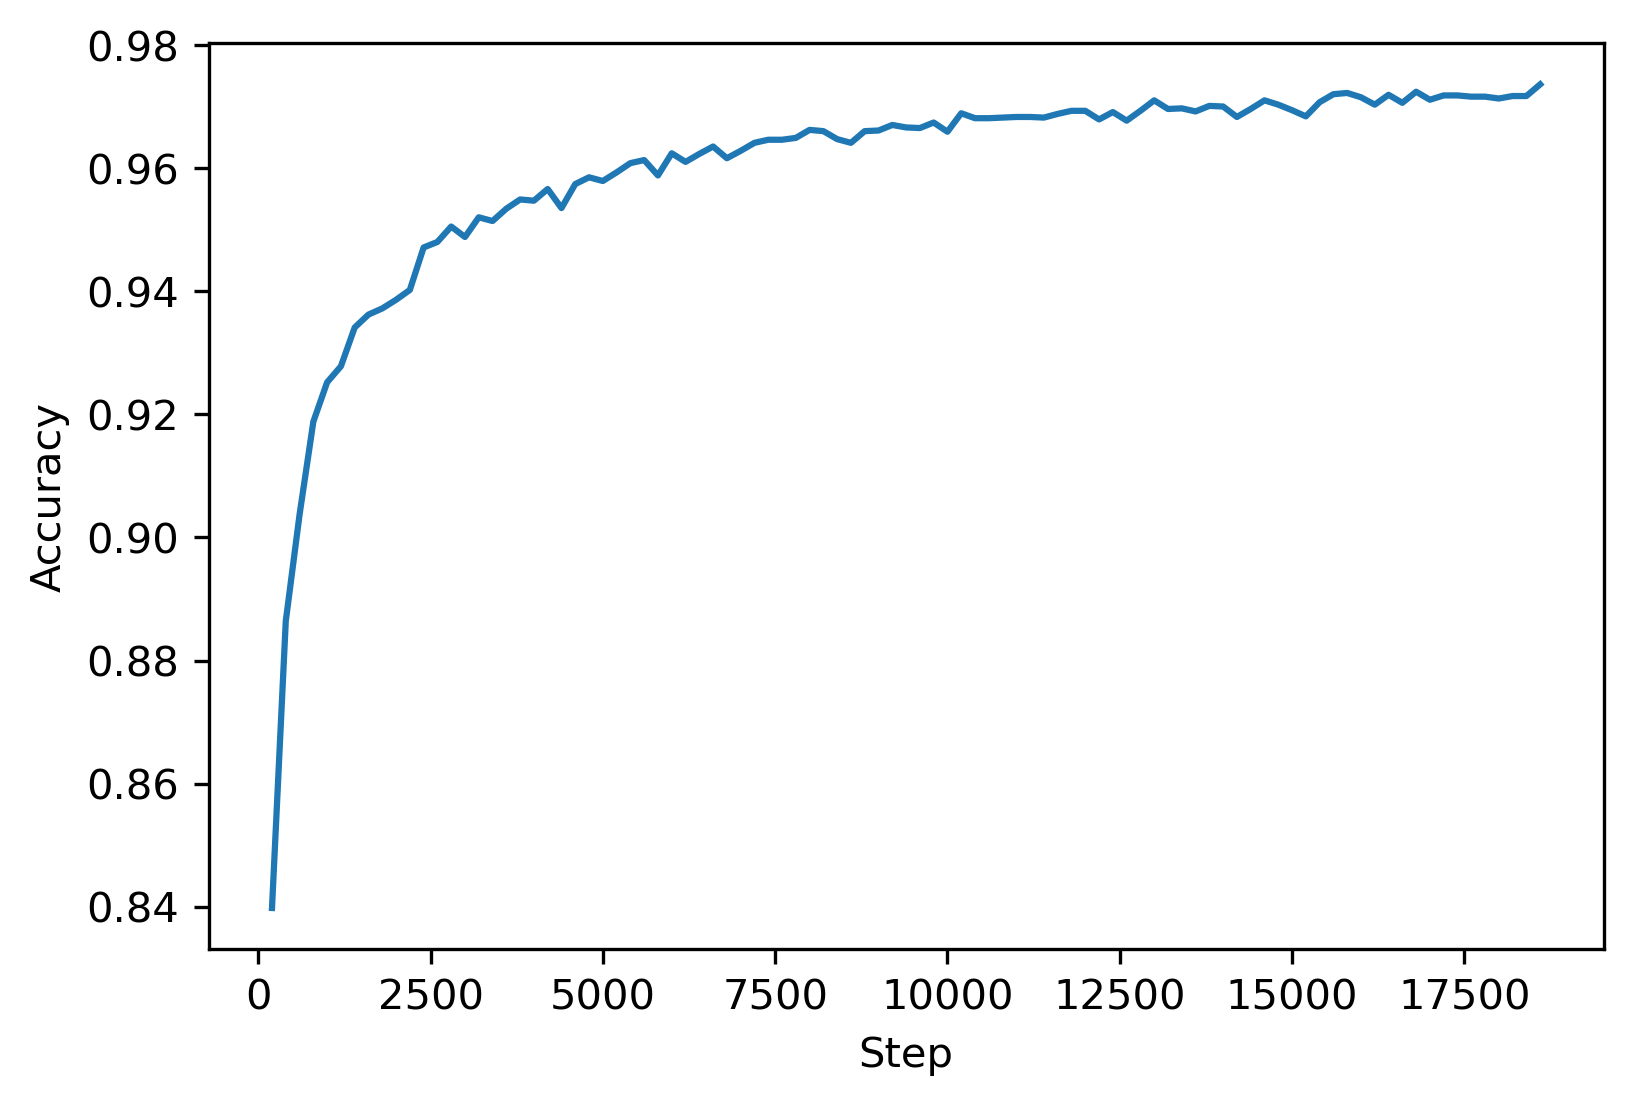

In [164]:
plt.figure(dpi=300)
plt.plot(*zip(*accuracy_history))
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.show()

In [165]:
torch.save(accuracy_history, "../results/predictive-coding/backprop/accuracy_history.pt")
torch.save(loss_history, "../results/predictive-coding/backprop/loss_history.pt")

backprop_accuracy_history = accuracy_history
backprop_loss_history = loss_history

In [24]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  pred = model(x0)
  pred_labels = pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.77%


## Activate before summation

In [166]:
W1 = W1_og.clone()
b1 = b1_og.clone()
W2 = W2_og.clone()
b2 = b2_og.clone()
W3 = W3_og.clone()
b3 = b3_og.clone()

In [167]:
step = 0
accuracy = 0
loss_history = []
accuracy_history = []

In [168]:
ir = 0.1
lr = 1e-2

In [124]:
# Training loop
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)
    u1 = x1 = x0 @ W1.T + b1
    u2 = x2 = activation1(x1) @ W2.T + b2
    u3 = x3 = activation2(x2) @ W3.T + b3
    u4 = softmax(x3)

    x4 = onehot(labels, n_classes=10)

    loss = -(torch.log(u4) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))


    e1 = x1 - u1
    e2 = x2 - u2
    e3 = x3 - u3
    e4 = x4 - u4
  
    # errors = []
    # errors.append((e1.abs().mean(), e2.abs().mean(), e3.abs().mean(), e4.abs().mean()))

    for i in range(1000):
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += ir * dx1

      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += ir * dx2

      dx3 = -e3 + e4
      x3 += ir * dx3

      # x3 is clamped

      u1 = x0 @ W1.T + b1
      e1 = x1 - u1

      u2 = activation1(x1) @ W2.T + b2
      e2 = x2 - u2

      u3 = activation2(x2) @ W3.T + b3
      e3 = x3 - u3

      u4 = softmax(x3)
      e4 = x4 - u4
      

    #   errors.append((e1.abs().mean(), e2.abs().mean(), e3.abs().mean(), e4.abs().mean()))

    # for errors in zip(*errors):
    #   plt.plot(errors)
    #   plt.show()
    # break 
  
    dW1 = e1[:, :, None] @ (x0)[:, None, :]
    db1 = e1
    dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
    db2 = e2
    dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]
    db3 = e3

    W1 += lr * dW1.mean(dim=0)
    b1 += lr * db1.mean(dim=0)

    W2 += lr * dW2.mean(dim=0)
    b2 += lr * db2.mean(dim=0)

    W3 += lr * dW3.mean(dim=0)
    b3 += lr * db3.mean(dim=0)


    if step % 100 == 0: 
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested

      accuracy_history.append((step, accuracy))



Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
  pred_labels = pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()
accuracy = correct / tested
print(accuracy)

tensor(0.5082)


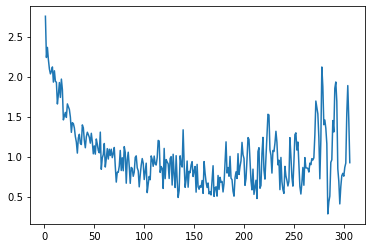

In [79]:
plt.plot(*zip(*loss_history))
plt.show()

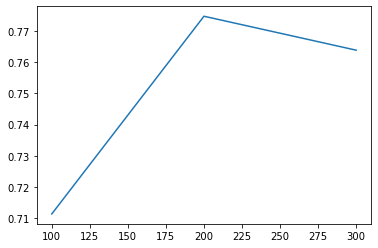

In [80]:
plt.plot(*zip(*accuracy_history))
plt.show()

In [169]:
W1 = W1_og.clone()
b1 = b1_og.clone()
W2 = W2_og.clone()
b2 = b2_og.clone()
W3 = W3_og.clone()
b3 = b3_og.clone()

In [170]:
step = 0
accuracy = 0
loss_history = []
accuracy_history = []

In [171]:
# Z-IL
# Training loop
for epoch in range(20):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)
    u1 = x1 = x0 @ W1.T + b1
    u2 = x2 = activation1(x1) @ W2.T + b2
    u3 = x3 = activation2(x2) @ W3.T + b3
    u4 = softmax(x3)

    x4 = onehot(labels, n_classes=10)

    loss = -(torch.log(u4) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))

    # errors = []
    for t in range(4):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = softmax(x3)

      e4 = x4 - u4

      e3 = x3 - u3
      dx3 = -e3 + e4
      x3 += dx3

      if t == 1:
        dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]
        db3 = e3
        W3 += lr * dW3.mean(dim=0)
        b3 += lr * db3.mean(dim=0)

      e2 = x2 - u2
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += dx2

      if t == 2:
        dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
        db2 = e2
        W2 += lr * dW2.mean(dim=0)
        b2 += lr * db2.mean(dim=0)

      e1 = x1 - u1
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += dx1

      if t == 3:
        dW1 = e1[:, :, None] @ x0[:, None, :]
        db1 = e1
        W1 += lr * dW1.mean(dim=0)
        b1 += lr * db1.mean(dim=0)

      #print(e1.abs().mean(), e2.abs().mean(), e3.abs().mean())
    #break

    if step % 100 == 0: 
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested

      accuracy_history.append((step, accuracy))

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20


  0%|          | 0/938 [00:00<?, ?it/s]

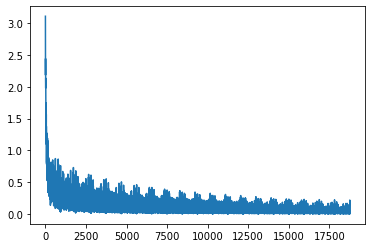

In [172]:
plt.plot(*zip(*loss_history))
plt.show()

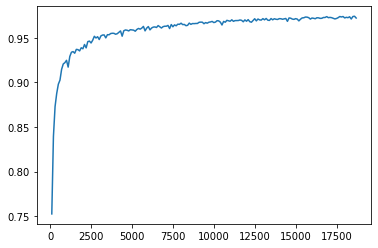

In [173]:
plt.plot(*zip(*accuracy_history))
plt.show()

In [174]:
zil_accuracy_history = accuracy_history
zil_loss_history = loss_history

In [192]:
torch.save((W1, b1, W2, b2, W3, b3), "../results/Z-IL.pt")

In [193]:
torch.save(model.state_dict(), "../results/bp-model.pt")

In [191]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
  pred_labels = pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 97.31%


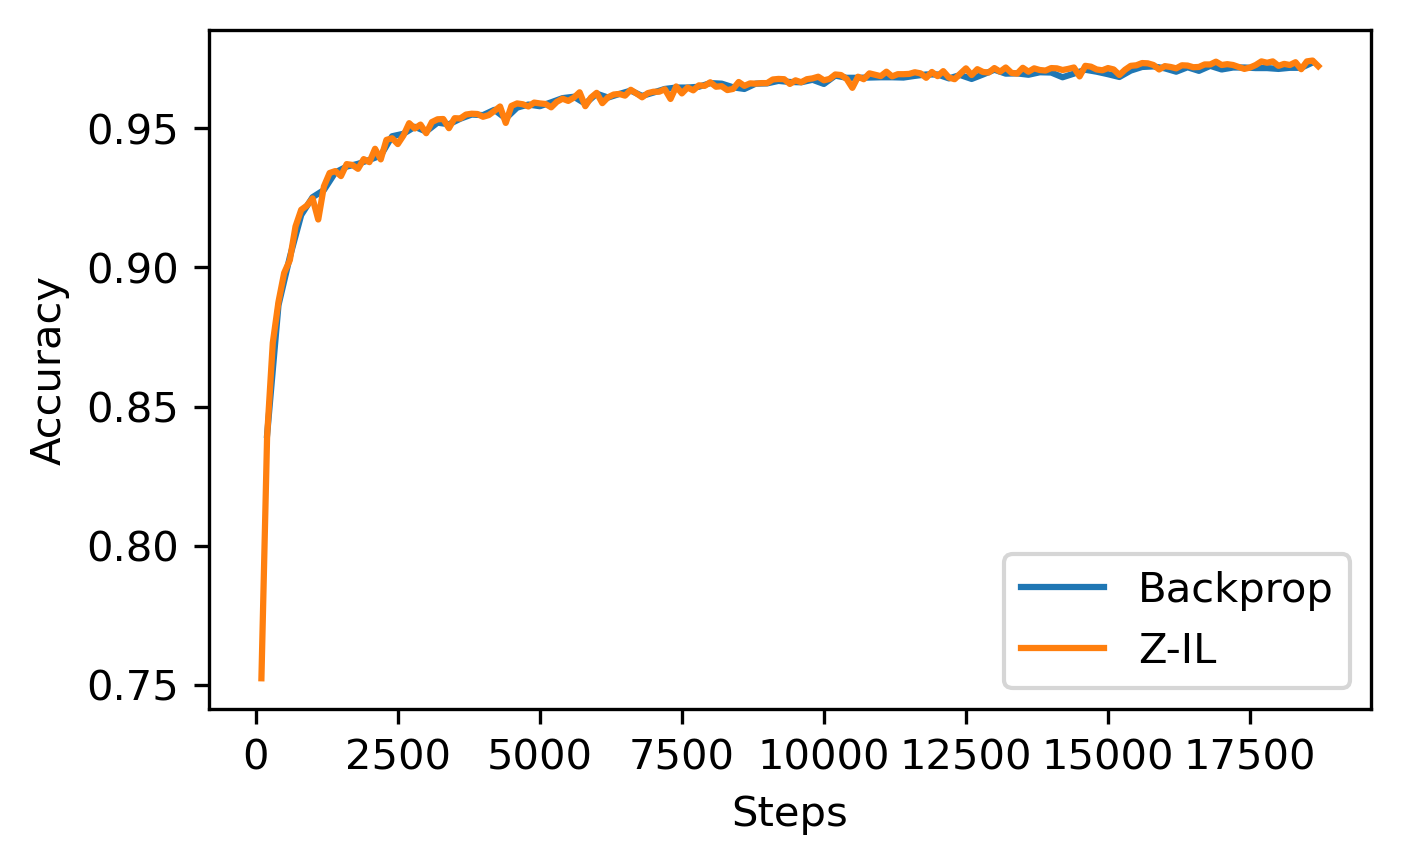

In [189]:
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(*zip(*backprop_accuracy_history))
plt.plot(*zip(*zil_accuracy_history))
plt.legend(["Backprop", "Z-IL"])
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.savefig("../report/graphics/Z-IL-backprop-accuracy.pdf", bbox_inches = "tight")
plt.show()


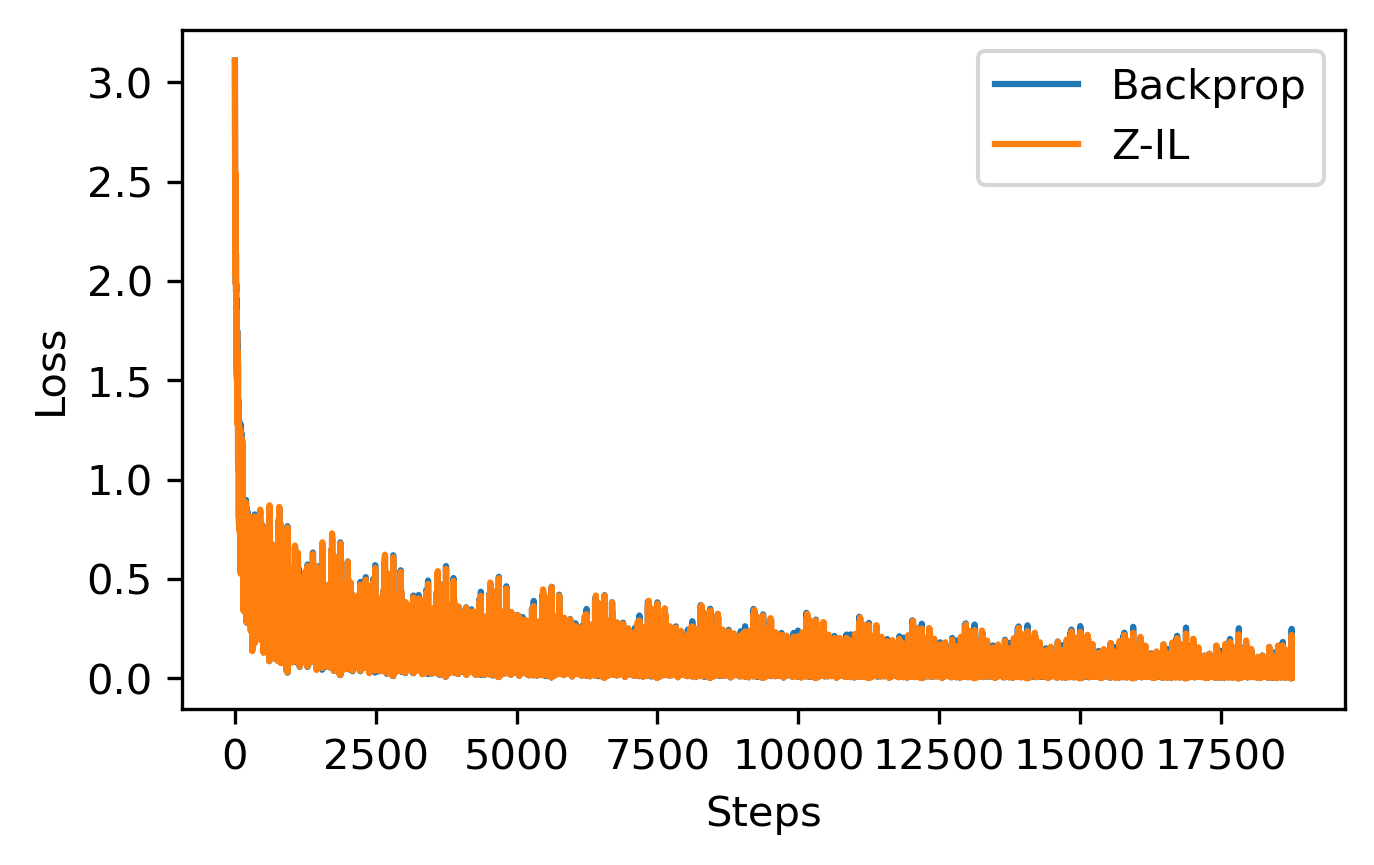

In [190]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(*zip(*backprop_loss_history))
plt.plot(*zip(*zil_loss_history))
plt.legend(["Backprop", "Z-IL"])
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.savefig("../report/graphics/Z-IL-backprop-loss.pdf", bbox_inches = "tight")
plt.show()